# **Deep Generative Models**



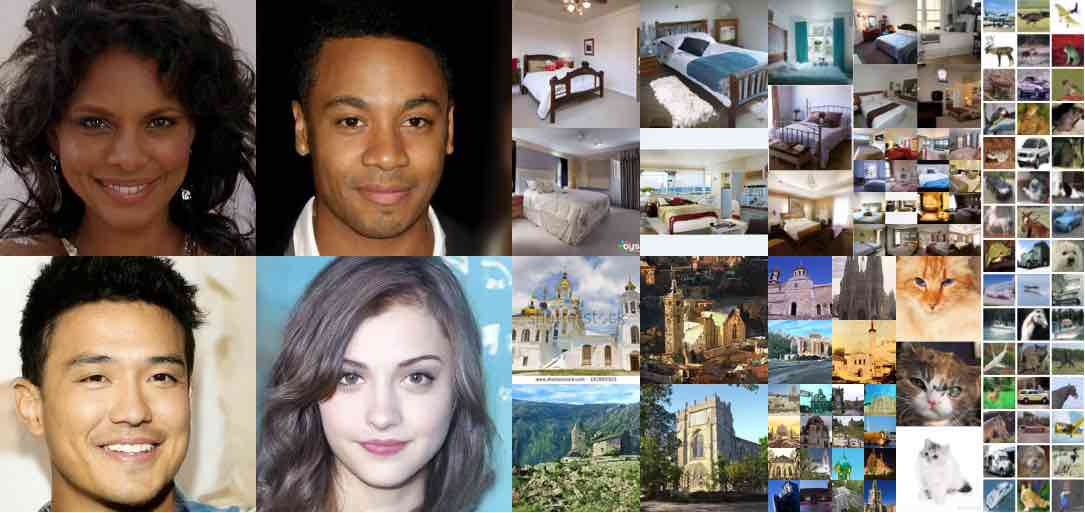

<a href="https://colab.research.google.com/drive/1-QhOqjSLEm_GN9gy7pAWAGsaIeEtUUEZ#forceEdit=true&sandboxMode=true" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:** James Allingham, Javier Antorán, Ruan van der Merwe

**Introduction:** 

In this practical, we will investigate the fundamentals of generative modelling – a machine learning framework that allows us to learn how to sample new unseen data points that match the distribution of our training dataset. Generative modelling, though a powerful and flexible framework–which has provided many exciting advances in ML–has its own challenges and limitations. This practical will walk you through such challenges and will illustrate how to solve them by implementing a Denoising Diffusion Model (a.k.a. a Score-Based Generative Model), which is the backbone of the recent and exciting [Dalle-2](https://openai.com/dall-e-2/) and [Imagen](https://imagen.research.google/) models that we’ve all seen on [Twitter](https://twitter.com/search?q=%23dalle2%20%23imagen&src=typed_query).

We'll focus on denoising diffusion models as presented in the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239) by Jonathan Ho, et al. (2020) as this paper introduced many simplifications and improvements to the model and was arguably one of the papers that first popularised this class of generative models. However, the original idea for the model was presented by Jascha Sohl-Dickstein, et al. (2015) in their paper ["Deep Unsupervised Learning using Nonequilibrium Thermodynamics"](https://arxiv.org/abs/1503.03585). Another classic paper on diffusion models is ["Generative Modeling by Estimating Gradients of the Data Distribution"](https://arxiv.org/abs/1907.05600) by Yang Song and Stefano Ermon (2019).

It is also worth noting that there are many perspectives from which we can understand diffusion models and that this practical focuses on just one. For example, one can define diffusion models in discrete or continuous time. At the end of the practical, we will provide some pointers to further reading.


Much of the material in this practical was adapted from and inspired by [The Annotated Diffusion Model blogpost](https://huggingface.co/blog/annotated-diffusion) by 🤗.

**Topics:** 

Content: <font color='blue'>`Generative Models`</font>, <font color='red'>`Probabilistic Graphical Models`</font> 

Level: Advanced.




**Aims/Learning Objectives:**


* Understand the differences between generative and discriminative modelling.
* Understand how the probabilistic approach to ML is key to generative modelling.
* Understand the challenges of building generative models in practice, as well as their solutions.
* Understand, implement, and train a denoising diffusion model.


**Prerequisites:**

* Familiarity with Jax and Haiku – going through the “Introduction to ML using Jax” practical is **strongly** recommended.
* Neural network basics (e.g., what ResNet, BatchNorm, and Adam are).
<!-- * Basic linear algebra. -->
* Basic probability theory (e.g., what a probability distribution is, what Bayes’ rule is).
* [Suggested] Attend the Monte Carlo 101 parallel – this session will provide a lot of background on probability theory.

**Outline:** 

>[Deep Generative Models](#scrollTo=m2s4kN_QPQVe)

>>[Installation and Imports](#scrollTo=6EqhIg1odqg0)

>>[Deep Generative Models](#scrollTo=Af0Sqm95helK)

>>>[[Optional] Quick Probability Refresher – The Sum, Product, and Bayes' rules](#scrollTo=M0xpQUsjlfnY)

>>>>[[Optional] Math Task](#scrollTo=rVHXcVWDljxY)

>>>>>[Answer to the math task (Try not to peek until you've given it a good try!')](#scrollTo=T6UsuU1ImRTs)

>>>>>[Answer to BONUS math task (Try not to peek until you've given it a good try!')](#scrollTo=v5OB2KDJp3hR)

>>>[What is Generative Modeling?](#scrollTo=0mfHQOmE4Agg)

>>>>[Generative and Discriminative Models are Two Sides of the Same Coin](#scrollTo=rQ5uDyDsjIxE)

>>>[Generative Models + NNs = Deep Generative Models](#scrollTo=Ie2YXVWR4ItU)

>>>>[The Challenge of Deep Generative Models](#scrollTo=Y5ct96ZK_MkE)

>>>>[Other Types of Deep Generative Models](#scrollTo=Bt089Bkpjb_w)

>>[Denoising Diffusion Models](#scrollTo=e9NW58_3hAg2)

>>>>[Score Function Illustration](#scrollTo=RHMaBPgTkcxF)

>>>>[Diffusion](#scrollTo=hL1UER25kLki)

>>>>[Putting the pieces together](#scrollTo=hkfbHhGZlwo9)

>>>[Training a Diffusion Model](#scrollTo=R8GjQPN2iNHh)

>>>>[The dataset](#scrollTo=oTveZRSCh9KK)

>>>>[Building the NN](#scrollTo=PAzSULmrh4_R)

>>>>[Training](#scrollTo=E2-yrQShiX2D)

>>>>>[Setup](#scrollTo=v6rcs8HY9CJW)

>>>>>[The Loss Function](#scrollTo=o8nzDkhZ6bLc)

>>>>>>[[Optional] Simplifying the Loss Function](#scrollTo=lrAawN7-4s1B)

>>>>>>[Implementing the Loss Function in jax](#scrollTo=z3QmO80f5L3l)

>>>>>[🚀 Go Time 🚀](#scrollTo=lbd8qQoG8pHC)

>>>>>[Sampling](#scrollTo=yR6TQQZ08lhc)

>>>>[[Optional] Guided diffusion](#scrollTo=QVAuiHsXfNJB)

>>>>[Exercises](#scrollTo=QISTyJf24hps)

>>>>[[Optional] Connections to Autoregressive Models, VAEs, NFs, and EBMs](#scrollTo=GMrkjFUbfQjQ)

>>>>>[Autoregressive models](#scrollTo=cL7moBbQxDou)

>>>>>[Variational Autoencoders (VAEs)](#scrollTo=cL7moBbQxDou)

>>>>>[Normalising Flows (NFs)](#scrollTo=cL7moBbQxDou)

>>>>>[Energy Based Models (EBMs)](#scrollTo=cL7moBbQxDou)

>[Conclusion](#scrollTo=fV3YG7QOZD-B)

>>[Feedback](#scrollTo=o1ndpYE50BpG)



**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Important:** you will also need to go to "Tools" >  "Settings" > "Miscellaneous" > check "Crab Mode".

## Installation and Imports

In [1]:
%%capture
## Install and import anything required. Capture hides the output from the cell. 
#@title Install and import required packages. (Run Cell)

%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.8

!pip install dm-haiku
!pip install optax
!pip install distrax
!pip install einops
!pip install livelossplot

import os 

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
  print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  print("Only CPU accelerator is connected.")

from functools import partial
import requests

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import haiku as hk
import optax
import distrax
import tensorflow as tf
import tensorflow_datasets as tfds
from einops import rearrange
from opt_einsum import contract
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from livelossplot import PlotLosses

matplotlib.rc('image', cmap='gray_r')

In [2]:
#@title Helper Functions. (Run Cell)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a[..., t]
    return jnp.reshape(out, (batch_size, *((1,) * (len(x_shape) - 1))))

  
def plot_log_gaussian_ellipse(ax, mean, cov, color='b', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[1, 2, 4, 6]):

  eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
  theta = np.linspace(0, 2*np.pi, 1200);
  std_ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ jnp.stack([np.sin(theta), np.cos(theta)])

  artists = []

  for level in std_levels:
    artists.append(ax.plot(mean[0] + level*std_ellipsis[0,:],
                           mean[1] + level*std_ellipsis[1,:], c=color,
                           alpha=alpha, lw=lw))
    
  artists.append(ax.scatter([mean[0]], [mean[1]], MAP_size, color=color,
                            label=label, alpha=alpha, marker='x'))

  return artists

In [3]:
#@title Check what device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [GpuDevice(id=0, process_index=0)]


## **Deep Generative Models**

### **[Optional] Quick Probability Refresher – The Sum, Product, and Bayes' rules**

In probability theory, three fundamental rules come up over and over again. So let's quickly recap them if they aren't at the tip of your mind. 

1. **The Product Rule:** $$p(x, y) = p(x|y)p(y) = p(y|x)p(x), $$ tells us that the joint probability distribution over two random variables, $x$ and $y$ in this example, is equal to the product of the probability distribution for one of those random variables, e.g. $p(x)$, multiplied by the conditional probability distribution of the second random variable given the first, $p(y|x)$. 


2. **Bayes' Rule:** $$p(y|x) = \frac{p(x|y)p(y)}{p(x)},$$ tells us how to convert between conditional distributions. That is, if we have $p(x|y)$ (as well as $p(x)$ and $p(y)$) we can convert it to $p(y|x))$ and vice-versa. This is a straightforward consequence of the product rule above.


3. **The Sum Rule:** $$p(x) = \sum_y p(x,y), $$ tells us that we can sum over (or marginalise) a random variable ($y$ in this example) in a joint probability distribution in order to get a distribution over the remaining random variable(s) ($x$ in this example). In the case of a continuous distribution, the sum $\sum$ would be replaced by an integral $\int$.



**An example to build intuition!**

Consider the joint Gaussian distribution 
$$ p(x, y) =  \mathcal{N}\left(\left[{\begin{array}{cc} 0.8 \\ 3.2 \\ \end{array}} \right]\, \middle|\, \mathbf{\mu}=\left[ {\begin{array}{cc}
    0.8 \\
    3.2 \\
  \end{array} } \right], \Sigma = \left[ {\begin{array}{cc}
    0.8 & -0.8 \\
    -0.8 & 2.0 \\
  \end{array} } \right]\right). $$

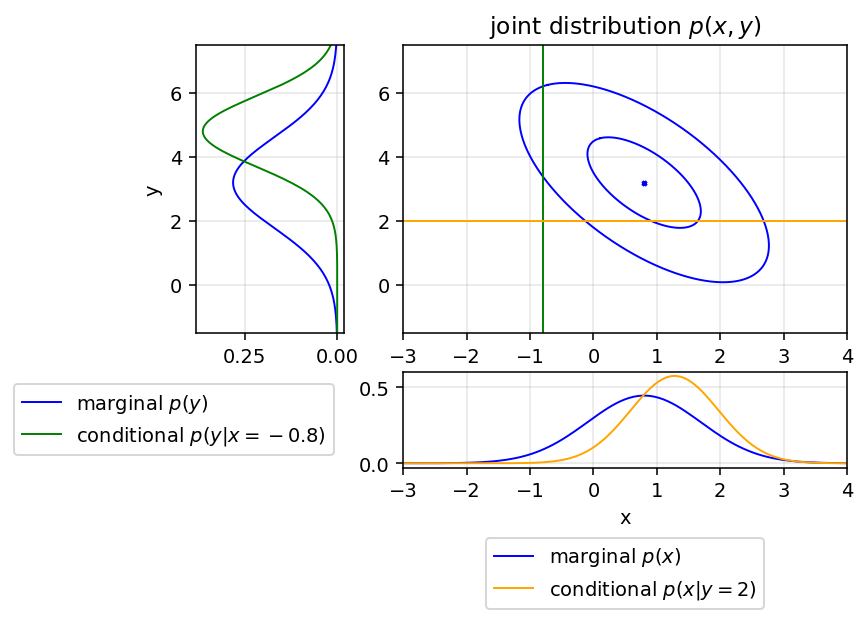

In [4]:
#@markdown Let's plot its marginals and conditionals! (Run Cell)

#@markdown The marginals over x and y are obtained by taking the joint and projecting it onto the x and y axis, respectively.

#@markdown The conditionals are obtained by choosing a line, such as x=-0.8 and projecting the other variable, i.e. y, onto that line.

from matplotlib import gridspec
from scipy.stats import norm

mean = np.array([0.8, 3.2])
covariance = np.array([[0.8, -0.8],[-0.8, 2.0]])

x_condition = -0.8
y_condition = 2

def Gaussian_conditional(mean, cov, x=None,y=None):
  assert not (x is None and y is None) and not (x is not None and y is not None)
  if x is not None:
    var = cov[1,1] -  cov[1,0] * cov[0,0] ** (-1) * cov[0,1]
    mu = mean[1] + cov[1,0] * cov[0,0] ** (-1) * (x - mean[0])
  else:
    var = cov[0,0] -  cov[0,1] * cov[1,1] ** (-1) * cov[1,0]
    mu = mean[0] + cov[0,1] * cov[1,1] ** (-1) * (y - mean[1])
  return mu, var

c_mu_y, c_var_y = Gaussian_conditional(mean, covariance, x=x_condition, y=None)
c_mu_x, c_var_x = Gaussian_conditional(mean, covariance, x=None, y=y_condition)

xrange = np.linspace(-10, 10, 300)
density_x = norm.pdf(xrange, 0.8, 0.8**0.5)
density_y = norm.pdf(xrange, 3.2, 2.0 ** 0.5)

cond_density_y = norm.pdf(xrange, c_mu_y, c_var_y ** 0.5)
cond_density_x = norm.pdf(xrange, c_mu_x, c_var_x ** 0.5)


plt.figure( dpi=140)
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

plot_log_gaussian_ellipse(ax, mean, covariance, color='b', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[1, 2.2])
ax.set_title('joint distribution $p(x, y)$')
ax.axvline(x_condition, lw=1, c='g')
ax.axhline(y_condition, lw=1, c='orange')

axb.plot(xrange, density_x, c='b', lw=1, label='marginal $p(x)$')
axb.plot(xrange, cond_density_x, c='orange', lw=1, label='conditional $p(x | y=2)$')
axb.set_xlabel('x')
axb.set_xlim([-3,4])
axb.legend(bbox_to_anchor=[0.5, -1.1], 
           loc='center')

axl.plot(density_y, xrange, c='b', lw=1, label='marginal $p(y)$')
axl.plot(cond_density_y, xrange, c='g', lw=1, label='conditional $p(y | x=-0.8)$')
axl.set_ylabel('y')
axl.set_ylim([-1.5,7.5])
axl.invert_xaxis() 
axl.legend(bbox_to_anchor=[-0.15, -0.3], 
           loc='center')

ax.grid(alpha=0.3)
axl.grid(alpha=0.3)
axb.grid(alpha=0.3)
plt.show()





#### **[Optional] Math Task**

Bayes' rule can actually be derived from only the product rule. Test your understanding by trying to derive it yourself (or with your neighbours)! 

$$ p(x, y) = \ldots $$

BONUS task: Go one step further and use the sum rule to write Bayes' rule without $p(x)$.

##### Answer to the math task (Try not to peek until you've given it a good try!') 


\begin{align}
p(x, y) & = p(y|x)p(x) && \triangleright \text{product rule}\\
\therefore p(y|x) &= \frac{p(x, y)}{p(x)} \\
&= \frac{p(x|y)p(y)}{p(x)} && \triangleright \text{product rule}
\end{align}

##### Answer to BONUS math task (Try not to peek until you've given it a good try!') 

\begin{align}
p(y|x) &= \frac{p(x|y)p(y)}{p(x)} \\
&= \frac{p(x|y)p(y)}{\sum_y p(x|y)p(y)}
\end{align}

### **What is Generative Modeling?**

One way that machine learning methods can be categorised is by whether they are *discriminative* or *generative*. Some of the most common machine learning tasks, such as regression and classification, are typically solved using discriminative methods. So you might be wondering "what is generative modelling?".

To understand what generative modelling is, let us compare and contrast it with discriminative modelling. Specifically, let us consider the task of modelling data from two different classes. 

**Discriminative:** In this case, we are interested in learning a probability distribution $p(y|x)$, i.e., the  probability of the class $y$ being either 0 or 1 given an example $x$. For any example $x$, we can determine whether it is more likely to be from class 0 or class 1, and draw a corresponding decision boundary where $p(y = 0|x) = p(y = 1|x)$. 

**Generative:** Here, we are interested in learning the probability distribution $p(x|y)$, i.e., the probability of observing some data $x$ given that it is from class $y$. We might also be interested in learning the probability distribution $p(x)$ which is the probability of observing $x$ in either of the classes. *The cool thing about generative modelling is that if we can sample $x \sim p(x|y)$ or $x \sim p(x)$ we can generate new unseen examples*. 



<img src="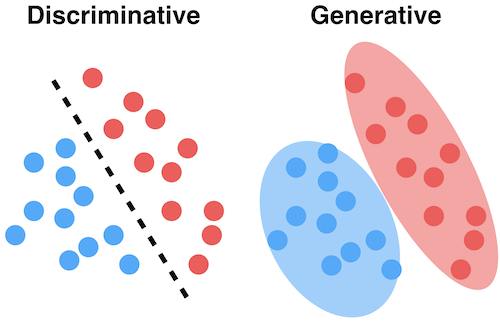
" width="60%" />



*In the picture above ([source](https://betterprogramming.pub/generative-vs-discriminative-models-d26def8fd64a_)), red and blue dots represent examples ($x$) from classes $y = 0$ and $y = 1$, respectively. The dashed black line shows the decision boundary in the discriminative case. In the generative case, the light red and blue ovals show the areas where $p(y = 0|x)$ and $p(y = 1|x)$ are large, respectively.* 

#### **Generative and Discriminative Models are Two Sides of the Same Coin**

From Bayes' rule $$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$ we can see that the discriminative model $p(y|x)$ and the generative model $p(x|y)$ are very closely linked. If we know $p(x)$ and $p(y)$ then we can convert between a generative and a discriminative model. However, as we will see in the next section, this isn't as easy as it might seem at first glance.

### **Generative Models + NNs = Deep Generative Models**

Now that we've discussed what a generative model is, we can answer the question "What is a **deep** generative model?". In this case, the answer is simple! A deep generative model is a generative model in which either $p_\theta (x)$ or $p_\theta (x|y)$ are represented by (deep) neural networks (with parameters $\theta$)!

To be more concrete, a deep generative model is a neural network that allows us to sample $x$ from the distribution $p_\theta(x)$ (or $p_\theta(x|y)$). This is often done by sampling random noise $z$ and using that as the input of the NN – in this case, the output of the NN is a sample $x$. Some deep generative models also allow us to evaluate $p_\theta(x)$ for a given example $x$, i.e., they allow us to measure the  probability of observing a particular example. 

<a name="challenge-dgms"></a>
#### **The Challenge of Deep Generative Models**

*The central problem of deep generative models is that we do not know how to write down the distribution $p_\theta(x)$.* 

**Task:** Discuss with your neighbour(s). Consider, for example, building a generative model for images of cats and dogs. What do you think the true distribution of such images is? How would you write that down mathematically? 

These are very difficult questions for humans to answer because images are very high dimensional and it is difficult for us to reason about high-dimensional spaces. 

The distribution $p_\theta(x|y)$ – e.g., the distribution of images of cats if we choose $y = \text{cat}$) – is similarly high dimensional and difficult for us to describe, so we are not saved by considering the conditional model. (This should not come as a surprise, since we know that $p_\theta(x)$ and $p_\theta(x|y)$ are closely tied together via Bayes' rule!)

**Why do we need to write down $p_\theta(x)$?** We said above that we would train a neural network to allow us to draw samples from $p_\theta(x)$, so if we don't need to evaluate the probability of those samples, why do we need to worry about writing down $p_\theta(x)$? Unfortunately, we need to **train** our model! If we don't train the model, we have no way of ensuring that the samples we draw actually come from the distribution $p_\theta(x)$! 

**How do we train our deep generative model?** From the probabilistic perspective, there is really only one way to train our model: we want to maximise $p_\theta(x)$ for our observed data. In practice, we will instead minimise (using SGD to optimise the weights $\theta$) the *negative log-likelihood* (NLL): $$ \mathcal{L}_\text{NLL} = -\sum_{n=1}^N \log p_\theta(x^{(n)}),$$
where $\{x^{(n)}\}_{n=1}^N$ is our training dataset. Thus, we need to be able to calculate $p(x^{(n)})$. 
Unfortunately, In some cases, this is not possible and we need to resort to various approximations. 

#### **Other Types of Deep Generative Models**







While we will be focusing on denoising diffusion models in this practical, it is worth keeping in mind that there are many other kinds of deep generative models. Different kinds of models make different assumptions with different pros and cons. Fundamentally, they all solve the problem of calculating $p(x)$ in different ways. Some common deep generative models include:

1. Autoregressive models,
2. Variational Autoencoders (VAEs),
3. Normalizing Flows (NFs),
4. Energy-based Models (EBMs), and
5. Generative Adversarial Networks (GANs)

## **Denoising Diffusion Models**





Denoising diffusion models avoid the problem of estimating $p_\theta(x)$ by instead estimating the *score function* $\nabla_x \log p_\theta(x)$, i.e., the gradient of the log-likelihood with respect to the observed data $x$. 
It is because of the importance of the score function that denoising diffusion models are also known as *score-based generative models*.

**Note.** The score function $\nabla_x \log p_\theta(x)$ is *not* the same as the gradient of the log-likelihood w.r.t the parameters of the model $\theta$: $\nabla_\theta \log p_\theta(x)$, which we would use to train other deep generative models such as NFs and autoregressive models. $\nabla_\theta \log p_\theta(x)$ tells us how to change the parameters of the model to increase the likelihood, while $\nabla_x \log p_\theta(x)$ tells us how to change the data itself!

#### **Score Function Illustration**



To get some intuition for what the score function is, and how we can use it to create samples from a desired distribution, let's consider a simple bi-modal distribution $$ p(\mathbf{x}) = 0.5 \cdot \mathcal{N}\left(\mathbf{x}\, \middle|\, \mathbf{\mu}=\left[ {\begin{array}{cc}
    0.8 \\
    3.2 \\
  \end{array} } \right], \Sigma = \left[ {\begin{array}{cc}
    0.8 & -0.8 \\
    -0.8 & 2.0 \\
  \end{array} } \right]\right) + 0.5 \cdot \mathcal{N}\left(\mathbf{x}\, \middle|\, \left[ {\begin{array}{cc}
    -1.3 \\
    -2.7 \\
  \end{array} } \right], \left[ {\begin{array}{cc}
    1.5 & 0.75 \\
    0.75 & 1.5 \\
  \end{array} } \right]\right). $$

  We can easily implement this density function in `jax` using the [`Distrax`](https://github.com/deepmind/distrax) library: 

In [5]:
dist_1 = distrax.MultivariateNormalFullCovariance([.8, 3.2], [[.8, -.8], [-.8, 2.]])
dist_2 = distrax.MultivariateNormalFullCovariance([-1.3, -2.7], [[1.5, .75], [.75, 1.5]])
density_fn = lambda x: 0.5*jnp.exp(dist_1.log_prob(x.astype(jnp.float32))) + 0.5*jnp.exp(dist_2.log_prob(x.astype(jnp.float32)))

**Code Task:** Use `jax`'s `grad` transform to implement the score function.

In [6]:
# score_fn =  # YOUR SOLUTION GOES HERE 

In [7]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 
score_fn = jax.grad(lambda x: jnp.log(density_fn(x)))

Now that we have the score function for $p(\mathbf{x})$, we can use it to take randomly sampled noise and transform it into samples from $p(\mathbf{x})$. The procedure is simple: start with an initial random guess $\mathbf{x}_T$, and then for $T$ *time*steps calculate $$ \mathbf{x}_{t-1} = \mathbf{x}_{t} + \lambda \cdot \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t), $$
until we arrive at $\mathbf{x}_0$, which we hope will be a sample from $p(\mathbf{x})$.
Here $\lambda$ is a step size parameter which controls how big a change we make at each timestep. We can implement this in code as:
```
for t in range(T):
    x = x + λ*score_fn(x)
```

**Group Task:**

1. Using the sliders below, experiment with randomly choosing different coordinates for $\mathbf{\mathbf{x}}_T$, as well as different values for $T$ and $\lambda$. 
2. Compare your initial coordinates $\mathbf{\mathbf{x}}_T$ (red crosses) with the final coordinates $\mathbf{\mathbf{x}}_0$ (cyan crosses). Which are more similar to the coordinates directly sampled from $p(\mathbf{\mathbf{x}})$ (black circles)? 
3. Discuss amongst yourselves to make sure that this behaviour makes sense.

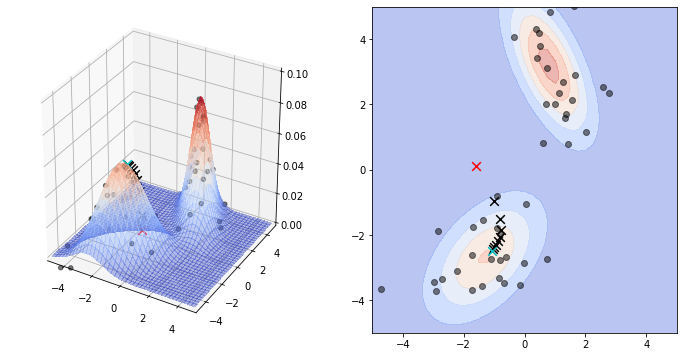

In [8]:
# @title Two Gaussians Score Function (Run Cell)
from matplotlib import cm

x0 =  -1.6 #@param {type:"slider", min:-5, max:5, step:0.1}
x1 =  0.1 #@param {type:"slider", min:-5, max:5, step:0.1}
x = jnp.array([x0, x1], dtype=jnp.float32)

T = 9 #@param {type:"slider", min:1, max:10, step:1}
λ = 0.4 #@param {type:"slider", min:0.1, max:1, step:0.05}


# Make plots of the density p(x)
X0 = jnp.arange(-5, 5.1, 0.25)
X1 = jnp.arange(-5, 5.1, 0.25)
X0, X1 = jnp.meshgrid(X0, X1)

Xs = jnp.concatenate(
    [X0.reshape(-1, 1), X1.reshape(-1, 1)], axis=1
)
Z = jax.vmap(density_fn)(Xs).reshape(X1.shape)


fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X0, X1, Z, cmap=cm.coolwarm,
                linewidth=0, alpha=0.4, antialiased=False)

ax2 = fig.add_subplot(122)
ax2.contourf(X0, X1, Z, cmap=cm.coolwarm,
            alpha=0.4, antialiased=False)


# Plot some samples from the true data distribution
key1, key2 = jax.random.split(jax.random.PRNGKey(42)) 
samples1, log_probs1 = dist_1.sample_and_log_prob(seed=key1, sample_shape=(25))
samples2, log_probs2 = dist_2.sample_and_log_prob(seed=key2, sample_shape=(25))  

log_probs = jnp.concatenate([log_probs1, log_probs2])
probs = 0.5*jnp.exp(log_probs)
samples = jnp.concatenate([samples1, samples2])

ax1.scatter(samples[:, 0], samples[:, 1], probs, c='k', marker='o', alpha=0.5)
ax2.scatter(samples[:, 0], samples[:, 1], c='k', marker='o', alpha=0.5)


# Plot the trajectory of the sample over time
ax1.scatter(x[0], x[1], density_fn(x), c='r', marker='x', s=75)
ax2.scatter(x[0], x[1], c='r', marker='x', s=75)

for t in range(T):
    x = x + λ*score_fn(x)

    color = 'k' if t < T - 1 else 'c'
    ax1.scatter(x[0], x[1], density_fn(x), c=color, marker='x', s=75)
    ax2.scatter(x[0], x[1], c=color, marker='x', s=75)  


ax1.set_ylim(-5, 5)
ax1.set_xlim(-5, 5)
ax1.set_zlim(0, 0.1)

ax2.set_ylim(-5, 5)
ax2.set_xlim(-5, 5)

plt.show()

<a name="diffusion"></a>
#### **Diffusion**

Before we can put everything we've learnt so far together, and define *what* a diffusion model is, and how to train it, we need to understand one more important concept: *diffusion*! 

We'll illustrate what diffusion is by means of an example. Consider an image $\mathbf{x_0}$, for example, the logo for the Deep Learning Indaba:

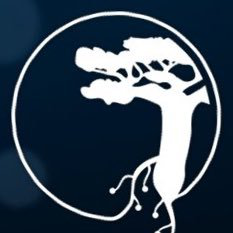

In [9]:
# @title Get DLI logo (Run Cell)
url = 'https://pbs.twimg.com/profile_images/1271511794650144770/oS8XqsX-_400x400.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

We can carefully add gaussian noise over $T$ timesteps to get slightly noisier images 
$$ \mathbf{x}_{t} = \sqrt{1 - \beta_t}\mathbf{x}_{t-1} + \sqrt{\beta_t} \cdot \boldsymbol\epsilon, \quad \boldsymbol\epsilon \sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right).$$ 
This is equivalent to writing 
$$ \mathbf{x}_{t} \sim \mathcal{N}\left(\sqrt{1 - \beta_t}\mathbf{x}_{t-1}, \beta_t \cdot \mathbf{I}\right) = q(\mathbf{x}_{t}|\mathbf{x}_{t-1}).$$

If we choose $\{\beta_t\}_{t=1}^T$ well, then $\mathbf{x}_{T}$ will be pure noise. I.e., we can say $\mathbf{x}_{T} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$.

The procedure that we have described is called a *forward diffusion process* and is where diffusion models get their name.

Now, let's code it up and see it in action! 

First, we need to define our $\{\beta_t\}_{t=1}^T$ values. The authors of the [Denoising Diffusion Probabilistic Models paper](https://arxiv.org/pdf/2006.11239.pdf), chose a simple linear schedule going from $\beta_1 = 1\times10^{-4}$ to $\beta_T = 0.02$.

**Code task:** implement this linear $\beta$ schedule using `jax.numpy`.

In [10]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return  # YOUR SOLUTION GOES HERE 

In [11]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

In [12]:
TIMESTEPS = 200

# Define beta schedule.
betas = linear_beta_schedule(timesteps=TIMESTEPS)

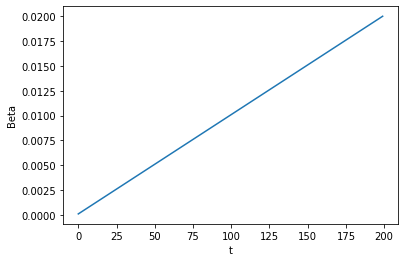

In [13]:
# @title Plot beta schedule (Run Cell)
plt.plot(betas)
plt.ylabel('Beta')
plt.xlabel('t')
plt.show()

Because we add Gaussian noise at each timestep, it is possible to sample $\mathbf{x}_{t}$ directly from $\mathbf{x}_{0}$, without first sampling $\mathbf{x}_{1}$, and then $\mathbf{x}_{2}$, and so on. 
$$ \mathbf{x}_{t} \sim \mathcal{N}\left( \sqrt{\bar{\alpha_t}} \mathbf{x}_{0}, (1 - \bar{\alpha_t})\cdot\mathbf{I} \right),$$ 
where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha_t} = \prod_{i=1}^t \alpha_i$.

We can use these alpha values to define the forward diffusion process given $\mathbf{x}_0$.

In [14]:
# Define alphas. 
alphas = 1. - betas
alphas_cumprod = jnp.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = jnp.sqrt(1. - alphas_cumprod)

In [15]:
# Forward diffusion - q(x_t|x_0):
def q_sample(x_start, t, noise):
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [16]:
# Helper function to convert an image into an array of the correct form
# and then apply the run forward diffusion.
def get_noisy_image(image, t, key):
    x_start = jnp.asarray(image, dtype=jnp.float32)[jnp.newaxis, ...]
    x_start = x_start / 255.  # normalize the images to [0, 1]
    x_start = (x_start * 2.) - 1.  # convert range to [-1, 1]

    # add noise
    noise = jax.random.normal(key, x_start.shape)
    x_noisy = q_sample(x_start, t, noise)

    # turn back into image format
    x_noisy = (x_noisy + 1.) / 2.
    x_noisy = x_noisy * 255.
    noisy_image = np.array(x_noisy).astype(jnp.uint8)[0]

    return noisy_image

Now we can finally see the forward diffusion process in action! Below we display $\mathbf{x}_0$, $\mathbf{x}_3$, $\mathbf{x}_{10}$, $\mathbf{x}_{30}$, $\mathbf{x}_{100}$, and $\mathbf{x}_{200 = T}$ from left to right.

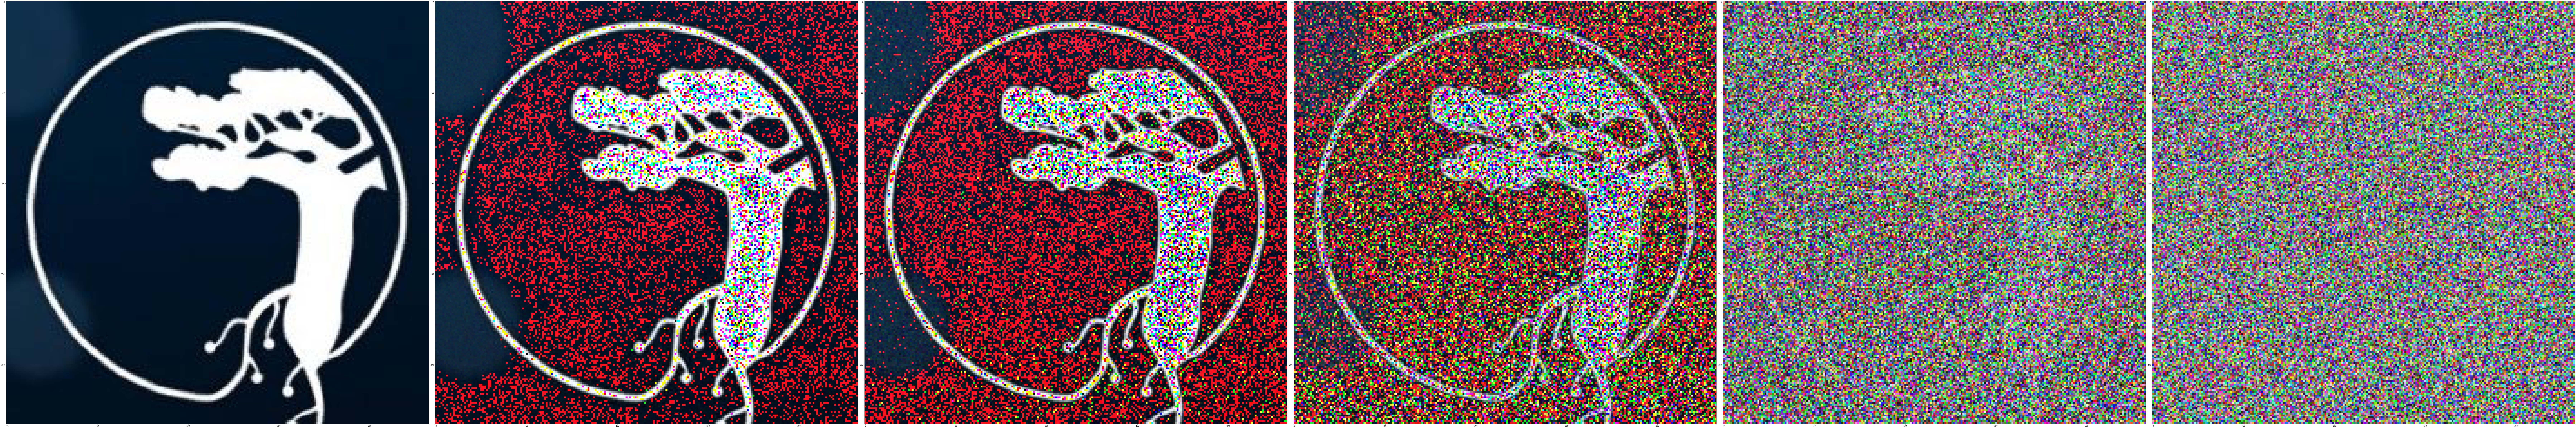

In [17]:
# @title Diffusion evolution (Run Cell)
ts = [2, 9, 29, 99, 199]
imgs = [image] + [get_noisy_image(image, jnp.array([t]), jax.random.PRNGKey(0)) for t in ts]

num_cols = len(imgs)
fig, axs = plt.subplots(figsize=(200,200), nrows=1, ncols=num_cols, squeeze=False)
for idx, img in enumerate(imgs):
    ax = axs[0, idx]
    ax.imshow(img)
    t = 0 if idx == 0 else ts[idx - 1] + 1

plt.tight_layout()

<a name="putting-it-together"></a>
#### **Putting the pieces together**

Since we know about score functions and diffusion, we are finally ready to define a denoising diffusion model!


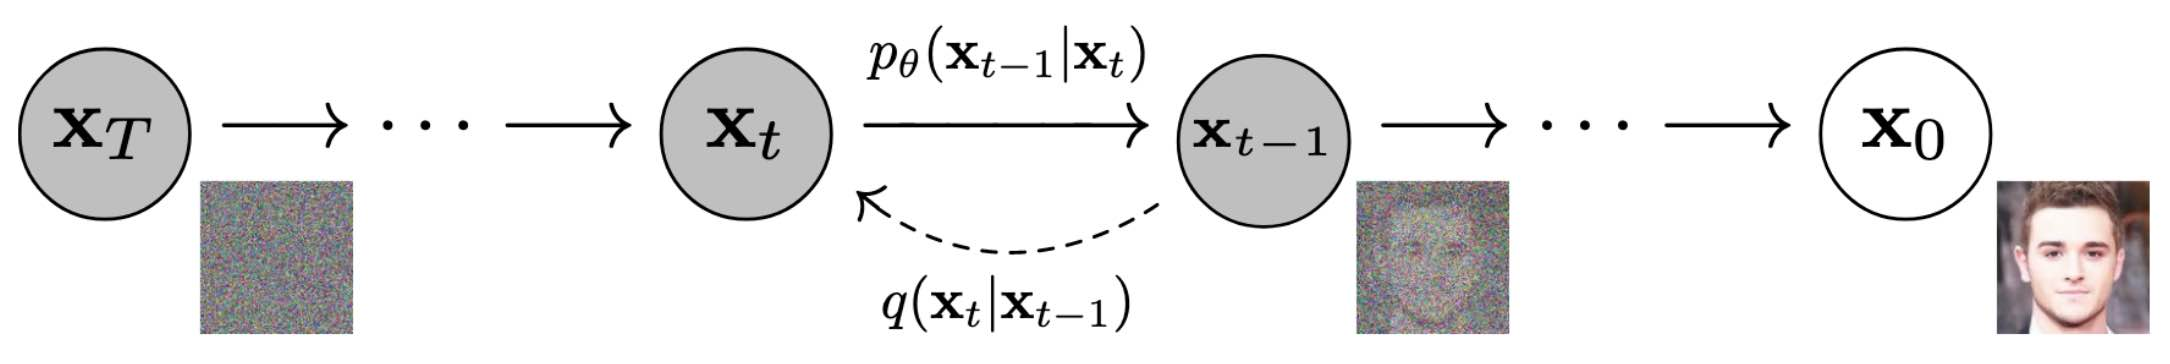

As shown in the above diagram from the paper, a diffusion model is comprised of two parts:
1. The *forward diffusion process* $q(\mathbf{x}_t|\mathbf{x}_{t-1})$ going from an image (or other data) $\mathbf{x}_0$, to noise $\mathbf{x}_T$ over $T$ timesteps. 
2. The *reverse process* $p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_{t})$ going from noise $\mathbf{x}_T$ to an image $\mathbf{x}_0$. 

In a denoising diffusion model, the *reverse process* $p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_{t})$ is equivalent to taking a step in the direction specified by the score function! In other words, at each timestep, we use a NN (with parameters $\theta$) to estimate the score function, and then take a step in the direction of higher likelihood! The reverse process is removing the noise added by the forward process, hence *denoising* in the name.

The equivalence between the score function and the reverse process isn't obvious, but hopefully you have some intuition for why this might be the case! 

**Task:** Discuss with a partner, does the relationship between the score function and reverse process make sense?

To provide a little more detail, let's assume that the *reverse process* takes the form
$$
p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_{t}) = \mathcal{N}\left(\mathbf{x}_{t-1}\middle| \mu_\theta(\mathbf{x}_{t}), \beta_t \cdot \mathbf{I} \right),
$$
where the mean is predicted by a NN and the variance is fixed to match the forward diffusion process. (The fixed variance was a choice made by Jonathan Ho et al., however, [follow-up work](https://openreview.net/forum?id=-NEXDKk8gZ) showed that predicting the variance with a NN, in addition to the mean, can improve performance.)

**Task:** Discuss with a partner, why it makes sense to assume a Gaussian distribution for the reverse process.

It turns out, that after some math<sup>1</sup>, we can rewrite the mean as 
$$
\mu_\theta(\mathbf{x}_{t}) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t)\right),
$$ 
where $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t)$ is noise, predicted by a NN, that we add to $\mathbf{x}_t$.

Now, if $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t) \approx \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)$, then the term in the brackets is approximately equivalent to taking a step with the score function:
$$
\mathbf{x}_t + \lambda\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t), 
$$
with $\lambda =  -\frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}$.


**Note:** Because we are using the same NN at each timestep, it helps to input $\mathbf{x}_{t}$ as well as the current timestep $t$ in order correctly predict the noise. That is, **rather than using $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t)$ we use $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)$**.

<sup>1</sup><font size='2'>This math is fairly involved so we won't go into it here. For more details, see [this fantastic blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#reverse-diffusion-process) or section 3 of [the paper](https://arxiv.org/pdf/2006.11239.pdf).</font>

### **Training a Diffusion Model**

The final piece of the puzzle for understanding diffusion models is how to train them! But before we go over that, let's quickly get some training data and define our neural network! 

#### **The dataset**

For this practical, we'll use the MNIST dataset of handwritten digits. While diffusion models are certainly powerful enough to handle more complicated datasets (all of the pictures in the cover image of this notebook were generated using diffusion models!), we'll use MNIST since it allows us to quickly train our models in Google Colab. As an exercise later we will try using the slightly more complicated FashionMNIST dataset. 

Let's load and visualise the dataset:



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


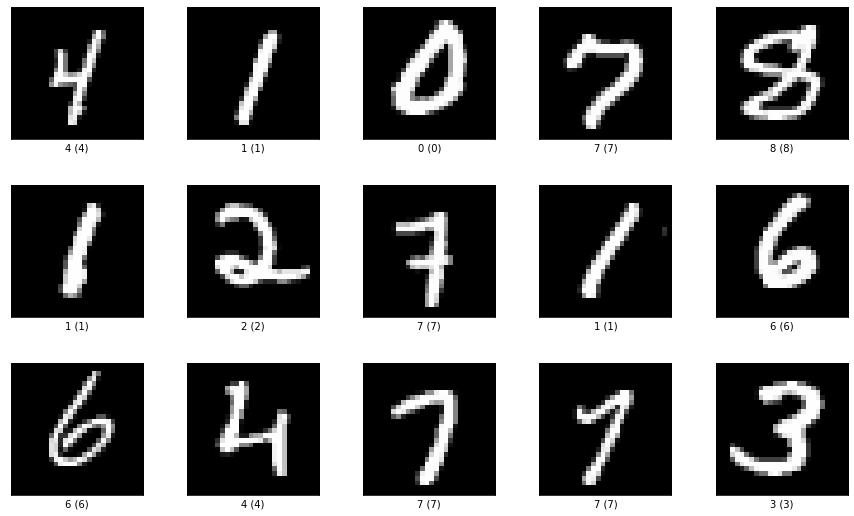

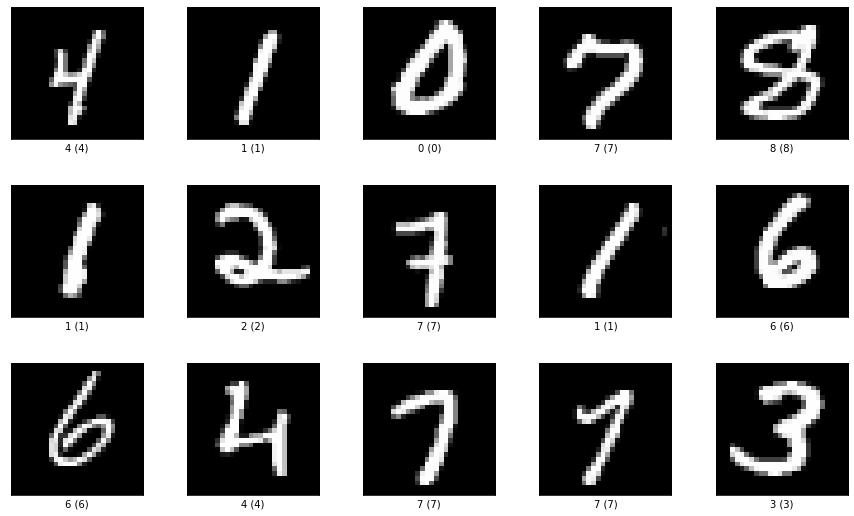

In [18]:
mnist, info = tfds.load('mnist', split='train', with_info=True)
tfds.show_examples(mnist, info, cols=5)

Now we'll create a simple data pipeline which will allow us to get batches of correctly formatted data.

We take the following steps:


1. We shuffle our dataset and repeat it so that we don't run out of examples.
2. We batch the data.
3. We take only the images (i.e., we discard the labels) in each batch. This is because we are training an unconditional generative model $p(\mathbf x)$. As an exercise later, you can try training a conditional model, so come back here to keep the labels.
4. We convert the images from `int8` to `float32` format.
5. We change the range of the pixels from $[0, 255]$ to $[-1., 1.]$.
6. We convert from the `tensorflow_datasets` format to a standard python iterator of `jax.numpy` arrays. 



In [19]:
BATCH_SIZE = 128
train_dataset = mnist.shuffle(10 * BATCH_SIZE, seed=0).cache().repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(lambda x: x['image'])
train_dataset = train_dataset.map(lambda x: tf.cast(x, tf.float32))
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)
train_dataset = iter(tfds.as_numpy(train_dataset))

#### **Building the NN**

The most common choice of NN architecture for $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)$ in (image) diffusion models is the [U-Net](https://arxiv.org/abs/1505.04597), which gets its name from the U-shape of the architecture as shown in the diagram below. 

Like an autoencoder, a U-Net consists of several downsampling stages in which the filter dimension of the image representation is first increased and then the spatial dimensions are downsampled, a bottleneck, and then several upsampling stages in which these downsampling transformations are reversed. The main difference between a U-Net and a standard autoencoder architecture is that at each stage in the upsampling path with include the original representation from the corresponding downsampling stage.

One motivation for using a U-Net rather than a standard autoencoder is that the final representation has information from various *frequencies*. Another is that the ResNet-like connections in the U-Net help with training due to improved gradient propagation.   

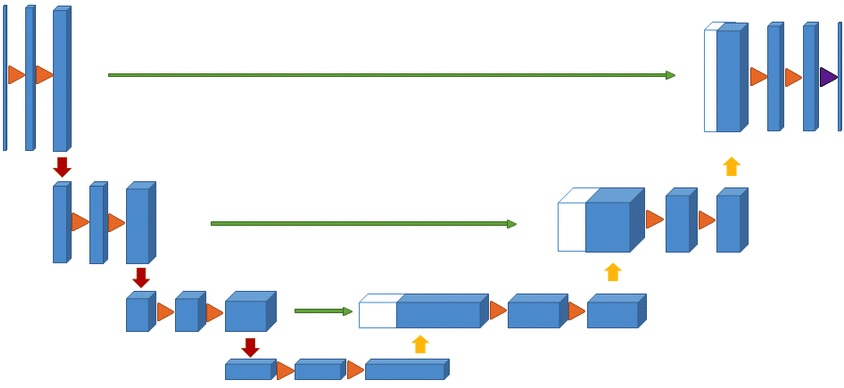


Above, we have a diagram of the U-Net architecture. Here, <font color='orange'>orange</font> arrows indicate ResNet blocks, <font color='red'>red</font> arrows indicate 2D convolutions used for *spatial* downsampling, <font color='goldenrod'>gold</font> arrows indicate 2D transposed convolutions used for *spatial* upsampling, <font color='green'>green</font> arrows indicate a copy and concatenate operation, and the <font color='purple'>purple</font> arrow indicates a final 2D convolution that outputs the correct number of channels. Figure adapted from [here](https://www.researchgate.net/figure/Typical-U-Net-style-architecture-44-The-success-of-this-network-comes-from-the-easy_fig5_343240820).

Let's define our U-Net in `haiku`. First, we'll define a number of building blocks, starting with an embedding layer for injecting $t$ into $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)$. If you'd like more information about how these kinds of embedding layers work, please see the [Transformers and Attention Practical](https://deeplearningindaba.com/2022/indaba/practicals/), which covers them in the context of positional embeddings for sequences.

In [20]:
class TimeEmbedding(hk.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, jnp.newaxis] * embeddings[jnp.newaxis, :]
        embeddings = jnp.concatenate((jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1)
        return embeddings

Next we define a ResNet layer consisting of two hidden layers. The ResNet also makes use of the time embedding to make its predictions time dependent. Don't worry too much about the hyperparameters such as the choice activation function and normalisation layer – these details aren't important for understanding how diffusion models work and were just copied from [a PyTorch implementation of diffusion models](https://github.com/lucidrains/denoising-diffusion-pytorch).

In [21]:
class Block(hk.Module):
    def __init__(self, dim_out, groups = 8):
        super().__init__()
        self.proj = hk.Conv2D(dim_out, kernel_shape=3, padding=(1, 1))
        self.norm = hk.GroupNorm(groups)
        self.act = jax.nn.silu

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x

class ResnetBlock(hk.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim_out, groups=8, change_dim=False):
        super().__init__()
        self.mlp = hk.Sequential([jax.nn.silu, hk.Linear(dim_out)])
        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = hk.Conv2D(dim_out, kernel_shape=1, padding=(0, 0)) if change_dim else lambda x: x

    def __call__(self, x, time_emb):
        h = self.block1(x)

        time_emb = self.mlp(time_emb)
        # We add new axes to the time embedding to for broadcasting.
        h = time_emb[:, jnp.newaxis, jnp.newaxis] + h

        h = self.block2(h)
        return h + self.res_conv(x)

Next, we define the up and down sampling operations.

In [22]:
def SpatialUpsample(dim):
    return hk.Conv2DTranspose(dim, kernel_shape=4, stride=2)

def SpatialDownsample(dim):
    return hk.Conv2D(dim, kernel_shape=4, stride=2, padding=(1, 1))

Finally, we are ready to define our U-Net!

**Code task:** In the `Unet` definition below, the downsampling path is fully defined, but the upsampling path is missing. Fill in the missing code. Use the downsampling path as a hint.

In [23]:
class Unet(hk.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4,),
        channels=3,
        resnet_block_groups=7,
    ):
        super().__init__()

        # determine dimensions
        init_dim = dim // 3 * 2
        self.init_conv = hk.Conv2D(init_dim, kernel_shape=7, padding=(3, 3))
        
        # time embeddings
        time_dim = dim * 4
        self.time_mlp = hk.Sequential([
            TimeEmbedding(dim),
            hk.Linear(time_dim),
            jax.nn.gelu,
            hk.Linear(time_dim),
        ])

        # layers
        self.downs = []
        dims = list(map(lambda m: dim * m, dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            self.downs.append([
                ResnetBlock(stage_dim, groups=resnet_block_groups, change_dim=True),
                ResnetBlock(stage_dim, groups=resnet_block_groups),
                # We don't apply spatial downsampling to the last stage. This is
                # because we go from 28x28 -> 14x14 -> 7x7 in the 1st and 2nd
                # stages and 7 can't be halved without a remainder, which
                # would cause problems in the upsampling path.
                SpatialDownsample(stage_dim) if not is_last else lambda x: x,
            ])

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, groups=resnet_block_groups)

        self.ups = []
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(rev_dims) - 1

            # YOUR SOLUTION GOES HERE 
            # Refer to the U-Net diagram if you need help.

        self.final_block = ResnetBlock(dim, groups=resnet_block_groups)
        self.final_conv = hk.Conv2D(channels, kernel_shape=1, padding=(0, 0))

    def __call__(self, x, t):
        x = self.init_conv(x)
        t = self.time_mlp(t)

        h = []
        # downsample
        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, upsample in self.ups:
            x = jnp.concatenate((x, h.pop()), axis=-1)
            # YOUR SOLUTION GOES HERE 
            # Refer to the U-Net diagram if you need help.

        x = self.final_block(x, t)
        return self.final_conv(x)

In [24]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

class Unet(hk.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4,),
        channels=3,
        resnet_block_groups=7,
    ):
        super().__init__()

        # determine dimensions
        init_dim = dim // 3 * 2
        self.init_conv = hk.Conv2D(init_dim, kernel_shape=7, padding=(3, 3))
        
        # time embeddings
        time_dim = dim * 4
        self.time_mlp = hk.Sequential([
            TimeEmbedding(dim),
            hk.Linear(time_dim),
            jax.nn.gelu,
            hk.Linear(time_dim),
        ])

        # layers
        self.downs = []
        dims = list(map(lambda m: dim * m, dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            self.downs.append([
                ResnetBlock(stage_dim, groups=resnet_block_groups, change_dim=True),
                ResnetBlock(stage_dim, groups=resnet_block_groups),
                # We don't apply spatial downsampling to the last stage. This is
                # because we go from 28x28 -> 14x14 -> 7x7 in the 1st and 2nd
                # stages and 7 can't be halved without a remainder, which
                # would cause problems in the upsampling path.
                SpatialDownsample(stage_dim) if not is_last else lambda x: x,
            ])

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, groups=resnet_block_groups)

        self.ups = []
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(rev_dims) - 1

            self.ups.append([
                ResnetBlock(stage_dim, groups=resnet_block_groups, change_dim=True),
                ResnetBlock(stage_dim, groups=resnet_block_groups),
                SpatialUpsample(stage_dim) if not is_last else lambda x: x,
            ])

        self.final_block = ResnetBlock(dim, groups=resnet_block_groups)
        self.final_conv = hk.Conv2D(channels, kernel_shape=1, padding=(0, 0))

    def __call__(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []
        # downsample
        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, upsample in self.ups:
            x = jnp.concatenate((x, h.pop()), axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        x = self.final_block(x, t)
        return self.final_conv(x)

#### **Training**

##### **Setup**

We specify some training hyperparameters and other constants.

In [25]:
LR = 3e-4
IMAGE_SIZE = 28
CHANNELS = 1

Now we define the forward function for our NN and apply appropriate `haiku` transformations, so that we can use it when we define the loss function.

In [26]:
def build_forward_fn(dim, channels):
    def forward_fn(x, t):
        """Forward pass."""
        model = Unet(dim, channels=channels)

        return model(x, t)

    return forward_fn

forward_fn = build_forward_fn(dim=IMAGE_SIZE, channels=CHANNELS)
# Convert from a stateful to a stateless forward function.
forward_fn = hk.transform(forward_fn)
# Remove unnecessary random seed from the forward function.
forward_fn = hk.without_apply_rng(forward_fn)

Let's also initialise our NN and optimiser.

In [27]:
# Initialise model.
init_rng = jax.random.PRNGKey(42)
dummy_input = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
params = forward_fn.init(init_rng, dummy_input, jnp.array([0]))

# Set up the optimiser.
optimiser = optax.adam(LR)
opt_state = optimiser.init(params)

##### **The Loss Function**



As we discussed back in [The Challenge of Deep Generative Models](#challenge-dgms), to train our generative model, we want to maximise the probability of the observed training data $p_\theta\left(\mathbf{x}\right)$. 

But, we don't know how to calculate $p_\theta(\mathbf{x})$. Luckily, we can use the structure of the diffusion model, and the rules of probability to solve this problem! 


Let's bring back the notion of time from the diffusion model and write observed data as $\mathbf{x}_0$. Then we know that $\mathbf{x}_0$ depends on all of the $\{\mathbf{x}_t\}_{t=1}^T$. Using the sum rule, we can write
$$
    p_\theta(\mathbf{x}_0) = \int_{\mathbf{x}_1, \ldots, \mathbf{x}_T} p_\theta(\mathbf{x}_0, \mathbf{x}_1, \ldots, \mathbf{x}_T)\, d \mathbf{x}_1 \ldots d \mathbf{x}_T.
$$
Then, using the product rule and our knowledge that $\mathbf{x}_t$ given $\mathbf{x}_{t+1}$ is independent of $\{\mathbf{x}_i\}_{i \ne t+1}$, we get
$$
    p_\theta(\mathbf{x}_0) = \int_{\mathbf{x}_1, \ldots, \mathbf{x}_T} p_\theta(\mathbf{x}_0 | \mathbf{x}_1) p_\theta(\mathbf{x}_1 | \mathbf{x}_2)\cdots p_\theta(\mathbf{x}_{T-1} | \mathbf{x}_T) p(\mathbf{x}_T)\, d \mathbf{x}_1  \ldots d \mathbf{x}_T.
$$

OK, we've made some progress! We've replaced $p_\theta(\mathbf{x}_0)$, which we didn't know how to calculate, with an integral of functions that we do know how to calculate:
* $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t})$, the reverse process in our diffusion model, which is predicted by a NN as described in [Putting the pieces together](#putting-it-together).
* $p(\mathbf{x}_T)$, which we can choose to be $\mathcal{N}(\mathbf{x}_T|\mathbf{0}, \mathbf{1})$.

However, we still aren't finished... Unfortunately, we can't evaluate this integral! 

**Group Task:** Discuss why this integral might be problematic. Think about how you would try to calculate it.

To solve this problem, we are going to use a trick from VAEs, the Evidence Lower BOund (ELBO). Let's multiply the integrand by $1 = \frac{q(\mathbf{x}_1|\mathbf{x}_0)}{q(\mathbf{x}_1|\mathbf{x}_0)} \cdots \frac{q(\mathbf{x}_T|\mathbf{x}_{T-1})}{q(\mathbf{x}_T|\mathbf{x}_{T-1})} $:
$$
    p_\theta(\mathbf{x}_0) = \int_{\mathbf{x}_1, \ldots, \mathbf{x}_T} p_\theta(\mathbf{x}_0 | \mathbf{x}_1) p_\theta(\mathbf{x}_1 | \mathbf{x}_2)\cdots p_\theta(\mathbf{x}_{T-1} | \mathbf{x}_T) p(\mathbf{x}_T) \frac{q(\mathbf{x}_1|\mathbf{x}_0)}{q(\mathbf{x}_1|\mathbf{x}_0)} \cdots \frac{q(\mathbf{x}_T|\mathbf{x}_{T-1})}{q(\mathbf{x}_T|\mathbf{x}_{T-1})}\, d \mathbf{x}_1  \ldots d \mathbf{x}_T.
$$
Note that the $q$ terms that we have introduced are just the forward diffusion process which we defined earlier and are easy to calculate. 

Now, using the definition of the expected value $\left(\mathbb{E}_{p}\left[f(x)\right] = \int_x f(x) p(x) dx \right)$ we can further simplify the above expression to get

$$
    p_\theta(\mathbf{x}_0) = \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0), \ldots, q(\mathbf{x}_T|\mathbf{x}_{T-1})} \left[\frac{p_\theta(\mathbf{x}_0 | \mathbf{x}_1)}{q(\mathbf{x}_1|\mathbf{x}_0)} \cdots \frac{p_\theta(\mathbf{x}_{T-1} | \mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_{T-1})}p(\mathbf{x}_T)\right].
$$

We now have an objective that we can calculate since we can use Monte Carlo to approximate the expectation. However, there is another problem, this objective is numerically unstable since both our numerator and denominator consist of many numbers between 0 and 1. This can easily lead to numerical underflow or overflow. The final steps to define our objective are to take a $\log$ (recall that the $\log$ function is concave and this doesn't change the optimisation problem), multiply both sides by $-1$, and then apply [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality)
\begin{align}
-\log p_\theta(\mathbf{x}_0) &= -\log \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0), \ldots, q(\mathbf{x}_{T}|\mathbf{x}_{T-1})} \left[\frac{p_\theta(\mathbf{x}_0 | \mathbf{x}_1)}{q(\mathbf{x}_1|\mathbf{x}_0)} \cdots \frac{p_\theta(\mathbf{x}_{T-1} | \mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_{T-1})}p(\mathbf{x}_T)\right] \\
&\le \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0), \ldots, q(\mathbf{x}_T|\mathbf{x}_{T-1})} \left[-\log \frac{p_\theta(\mathbf{x}_0 | \mathbf{x}_1)}{q(\mathbf{x}_1|\mathbf{x}_0)} - \cdots - \log \frac{p_\theta(\mathbf{x}_{T-1} | \mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_{T-1})} - \log p(\mathbf{x}_T)\right].
\end{align}

**Group Task:** Convince yourselves that a) we can calculate the expression on the last line above, and b) minimizing this expression is equivalent to maximising $p_\theta(\mathbf{x}_0)$.

###### **[Optional] Simplifying the Loss Function**

While the loss function that we have just defined is valid, there are several simplifications that we can make. These simplifications end up making training the diffusion model easier in practice. In this section, we will not go over the exact simplifications used in the paper, as this involves more math than we have time for here<sup>2</sup>. Instead, we'll build some intuition for the kinds of simplifications that are presented in the paper. 

\
**Step 0:** To start, we will rewrite our loss, as described in section 2 of the paper, resulting in
$$
\mathcal{L} = \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0), q(\mathbf{x}_1|\mathbf{x}_2, \mathbf{x}_0), \ldots, q(\mathbf{x}_{T-1}|\mathbf{x}_{T}, \mathbf{x}_0)q(\mathbf{x}_T|\mathbf{x}_{0})} 
\left[
-\log p_\theta(\mathbf{x}_0 | \mathbf{x}_1) - \sum_{t>1} \left( \log \frac{p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t)}{q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)} \right) - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_0)}
\right],
$$
where $q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}\left(\frac{\sqrt{\bar\alpha_{t-1}}\beta_t }{1-\bar\alpha_t}\mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1- \bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t, \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\beta_t \cdot \mathbf{I} \right)$.

\
**Step 1:** Dropping the $\log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_{T-1})}$ term. This term doesn't have any learnable parameters, thus when we take gradients of the loss with respect to $\theta$ it will disappear anyway. Our loss is then
$$
\mathcal{L} = \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0), q(\mathbf{x}_1|\mathbf{x}_2, \mathbf{x}_0), \ldots, q(\mathbf{x}_{T-1}|\mathbf{x}_{T}, \mathbf{x}_0)}
\left[
-\log p_\theta(\mathbf{x}_0 | \mathbf{x}_1) - \sum_{t>1} \left( \log \frac{p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t)}{q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)} \right)
\right].
$$
For the following simplification steps, let's ignore the $\log p_\theta(\mathbf{x}_0 | \mathbf{x}_1)$ term, to keep the explanations simple. 

\
**Step 2:** Optimise random terms of $\mathcal{L}$, corresponding to random timesteps. Our loss now becomes
$$
\mathcal{L} = \mathbb{E}_{\mathcal{U}(t|2, T)} \left[\mathbb{E}_{q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)}
\left[
- \log \frac{p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t})}{q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)}
\right]\right],
$$
where $\mathcal{U}(t|2, T)$ is a discrete uniform distribution for values of $t$ between 2 and $T$. This is a valid loss function because the expected value is the same. However, it does have a higher variance than the loss in Step 1. So why would we make this change? Well, it allows us to do very efficient training. This is because we have an analytical expression for $q(\mathbf{x}_t|\mathbf{x}_0)$, allowing us to sample $\mathbf{x}_t$ directly from $\mathbf{x}_0$, as discussed in [Diffusion](#diffusion). The training is now more efficient because if we approximate the expectation over $t$ with a single Monte-Carlo sample
$$
\mathcal{L} = \mathbb{E}_{q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}
\left[
- \log \frac{p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t})}{q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)}
\right], \quad t \sim \mathcal{U}(t|2, T).
$$
we only have to evaluate our U-Net 1 time, rather than T times, per example.

\
**Step 3:** Replace the expectation with an analytical solution. Note that the expectation above is equivalent to the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between $q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)$ and $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t})$:
$$
\mathcal{L} = D_\text{KL}\left(q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)\middle|\middle| p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t})\right), \quad t \sim \mathcal{U}(t|2, T).
$$
As discussed in [Putting the pieces together](#putting-it-together), $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t}) = \mathcal{N}\left(\mathbf{x}_{t-1}\middle| \mu_\theta(\mathbf{x}_{t}, t), \beta_{t+1} \cdot \mathbf{I} \right)$. Both distributions are Gaussian which means that the KL-divergence has a closed form expression
\begin{align}
&D_\text{KL}\left(q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)\middle|\middle| p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_{t})\right) \\
%
&= \frac{1}{2}\left(\text{Tr}\left(\Sigma_q^{-1}\Sigma_p\right) - \mathtt{image\_dim} + \left(\mu_q - \mu_p  \right)^{\top}\Sigma_q^{-1}\left(\mu_q - \mu_p  \right) + \log\left(\frac{\text{Det}\Sigma_q}{\text{Det} \Sigma_p}\right)\right) \\
%
&= \frac{1}{2\sigma_q^2} || \mu_q - \mu_p ||^2 + C,
\end{align}
where $C$ is a constant that does not depend on $\theta$. Plugging in the expressions $\mu_q$, $\mu_p$, and $\sigma_q^2$, and dropping $C$, we get 
$$
\mathcal{L} = 
\frac{1}{2 \beta_t} \left|\left| \frac{\sqrt{\bar\alpha_{t-1}}\beta_t }{1-\bar\alpha_t}\mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1- \bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t - \mu_\theta(\mathbf{x}_{t}, t) \right|\right|^2, \quad t \sim \mathcal{U}(t|2, T).
$$

\
**Steps 4 and 5:** There are two final steps. The first is to reparameterise to predict the noise added to our input rather than the mean of the noisy sample. The second is to ignore the factor in front of the 2-norm.

<sup>2</sup><font size='2'>For more details, see [this fantastic blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#reverse-diffusion-process) or section 3 of [the paper](https://arxiv.org/pdf/2006.11239.pdf).</font>

###### **Implementing the Loss Function in `jax`**

If you skipped the optional section above, the TL;DR is that our loss function can be simplified to
$$
\mathcal{L} = ||\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)||^2,
$$
which is simply the mean squared error between the noise added in timestep $t$ of the forward diffusion process ($\boldsymbol{\epsilon}$) and the noise predicted by our neural network for the same time step ($\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)$). 

Hopefully, even without the optional discussion above, you have some intuition for why this might make sense. *Hint:* think about training the forward diffusion process to match the reverse process (i.e., the score function). 

**Code task:**

In [28]:
@jax.jit
def loss_fn(params, x_0, t, ϵ):
    # Sample x_t from the forward diffusion process - q(x_t|x_0):
    # x_t = YOUR SOLUTION GOES HERE

    # Predict ϵ using our U-Net with inputs x_t and t:
    # predicted_ϵ = YOUR SOLUTION GOES HERE
    
    # Calculate the loss as the mean squared error between the true and predicted ϵs: 
    # loss = YOUR SOLUTION GOES HERE

    return loss

In [29]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 
@jax.jit
def loss_fn(params, x_0, t, ϵ):
    # Sample x_t from the forward diffusion process - q(x_t|x_0):
    x_t = q_sample(x_start=x_batch, t=t, noise=ϵ)

    # Predict ϵ using our U-Net with inputs x_t and t:
    predicted_ϵ = forward_fn.apply(params, x_t, t)

    # Calculate the loss as the mean squared error between the true and predicted ϵs: 
    loss = jnp.mean((ϵ - predicted_ϵ)**2)

    return loss

Now we can use our loss function to define the update step for training our diffusion model.

In [30]:
@jax.jit
def update(params, opt_state, batch, t, noise):
  loss, grads = jax.value_and_grad(loss_fn)(params, batch, t, noise)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

##### 🚀 **Go Time** 🚀

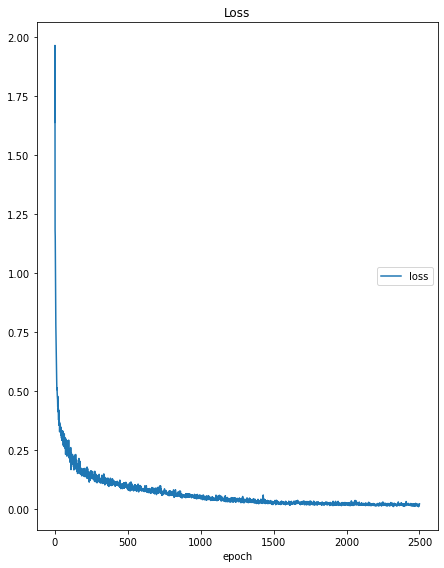

Loss
	loss             	 (min:    0.009, max:    1.964, cur:    0.021)
CPU times: user 4min 54s, sys: 22.4 s, total: 5min 17s
Wall time: 4min 50s


In [31]:
%%time
plotlosses = PlotLosses()

MAX_STEPS = 2501
key = jax.random.PRNGKey(42)

# TODO: fix memory leak

best_loss = jnp.inf
for step in range(MAX_STEPS):
    key, noise_key, time_key, sample_key = jax.random.split(key, num=4)

    x_batch = next(train_dataset)
    batch_size = x_batch.shape[0]

    t = jax.random.randint(time_key, (batch_size,), 0, TIMESTEPS)
    noise = jax.random.normal(noise_key, x_batch.shape)
    params, opt_state, loss = update(params, opt_state, x_batch, t, noise)

    if loss < best_loss:
        best_params = params
        best_loss = loss

    plotlosses.update({'loss': loss})
    if step % 50 == 0:
        plotlosses.send()

##### **Sampling**

In [32]:
sqrt_recip_alphas = jnp.sqrt(1.0 / alphas)

alphas_cumprod_prev = jnp.concatenate((jnp.array([1.0]), alphas_cumprod[:-1]))
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

@partial(jax.jit, static_argnums=4)
def sample_iteration(params, key, x, t, add_noise=True):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * forward_fn.apply(params, x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = extract(posterior_variance, t, x.shape)
    noise = jax.random.normal(key, x.shape)

    # Algorithm 2 line 4:
    return model_mean + jnp.sqrt(posterior_variance_t) * noise 

# Algorithm 2 in the paper
def sample(params, key, image_size, batch_size=16, channels=3):
    shape = (batch_size, image_size, image_size, channels)

    img_key, key = jax.random.split(key, num=2)
    # start from pure noise (for each example in the batch)
    img = jax.random.normal(img_key, shape)
    imgs = []
    
    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='sampling loop time step', total=TIMESTEPS):
        noise_key, key = jax.random.split(key, num=2)
        img = sample_iteration(params, noise_key, img, jnp.full((batch_size,), i), i != 0)
        imgs.append(img)

    return imgs

In [33]:
samples = sample(best_params, key, IMAGE_SIZE, 25, CHANNELS)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

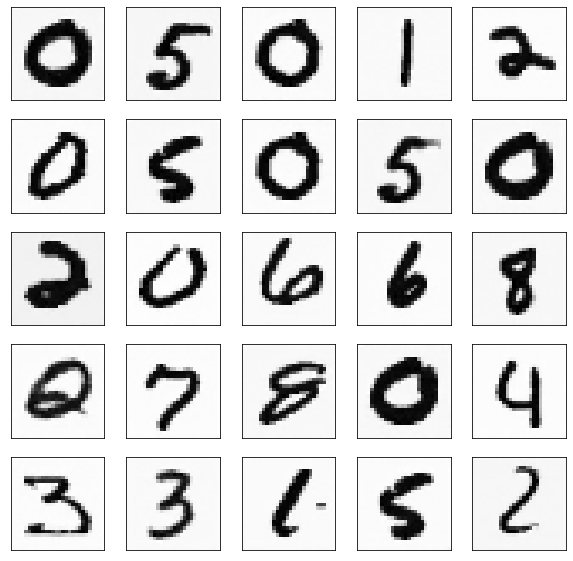

In [34]:
# @title Show samples (Run Cell)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(samples[-1][i][:, :, 0])

In [35]:
# @title Animate diffusion (Run Cell)
sample_index = 13  # @param

fig = plt.figure()
ims = []
for i in range(TIMESTEPS):
    im = plt.imshow(samples[i][sample_index][:, :, 0], animated=True)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=5000)
plt.close()

HTML(animate.to_html5_video())

#### **[Optional] Guided diffusion**

[TODO] explain guided diffusion 

[Classifier Free Diffusion Guidance](https://openreview.net/pdf?id=qw8AKxfYbI)

https://benanne.github.io/2022/05/26/guidance.html

#### **Exercises** 

1. [All] Discuss with your neighbour(s), what a deep generative model is. Make sure you understand the challenges compared to a discriminative model are, and what the *deep* in the name means. Next, discuss what a denoising diffusion model is. Make sure you understand both the *denoising* and *diffusion* parts.
2. [Beginner] Try to train on FashionMNIST. This is a more difficult dataset so you might want to try making the U-Net more powerful and training for longer.
3. [Intermediate] Add label information to make a conditional generative model $p(x|y)$.
4. [Advanced] Implement classifier-free guidance.

#### **[Optional] Connections to Autoregressive Models, VAEs, NFs, and EBMs**

##### **Autoregressive models** 

Autoregressive models assume that the probability distribution over a $D$ dimensional observation $\mathbf{x}$ factorises as $$ p(\mathbf{x}) = p(x_1) \prod_{d=1}^{D-1} p(x_{d+1}|x_{d},...,x_1), $$ where $x_d$ is the $d^{th}$ element of $\mathbf{x}$. This assumption allows us to choose simple distributions for each $p(x_d|...)$ but still have a complex overall distribution for $p(\mathbf{x})$. However, these models are very expensive to train and sample from due to the conditional structure. Furthermore, it is not clear what the correct ordering of the dimensions of $\mathbf{x}$ is. Nevertheless, autoregressive models have seen huge success – a prime example being [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)!

**Fun fact:** Autoregressive models are intimately related to denoising diffusion models. Specifically, denoising diffusion models can be understood as autoregressive models where the factorisation is across timesteps instead of dimensions.

##### **Variational Autoencoders (VAEs)** 

VAEs model $p(\mathbf{x})$ as a transformation of some simple noise distribution $p(\mathbf{z})$, which is often chosen to be a simple Gaussian. A neural network $\mu(\mathbf{z})$ is chosen to learn the mapping from $\mathbf{z}$ to $\mathbf{x}$. Since we assume that most of the structure of $\mathbf{x}$ will be modelled by this neural network, we choose the conditional distribution $p(\mathbf{x}|\mathbf{z})$ to also be a simple Gaussian, centred at $\mu(\mathbf{z})$. This conditional distribution just captures the residuals of the neural network's reconstructions. The full distribution over images is thus written as
$$p(\mathbf{x}) = \int p(\mathbf{x}|\mathbf{z}) p(\mathbf{z}) \,d \mathbf{z}.$$ 
Since we can evaluate both $p(\mathbf{x}|\mathbf{z})$ and $p(\mathbf{z})$ due to them being simple distributions, we could in principle, estimate $p(\mathbf{x})$ using Monte Carlo methods. However, for high-dimensional data $\mathbf{x}$, such as images, this would have very high variance, preventing any learning.

The solution is to introduce an inference model $q(\mathbf{z}|\mathbf{x})$. This distribution is also chosen to be a simple Gaussian and is also parametrised by a neural network. For each $\mathbf{x}$ in our training data, $q(\mathbf{z}|\mathbf{x})$ aims to approximate the posterior $p(\mathbf{z}|\mathbf{x})$. This allows us to construct an Evidence Lower BOund (ELBO), a training objective with much lower variance which, as the name implies, is a lower bound on $\log p(\mathbf{x})$:
$$\log p(\mathbf{x}) \geq \textrm{ELBO} = \mathbb{E}_q(\mathbf{z}|\mathbf{x})[\log p(\mathbf{x}|\mathbf{z})] - D_\textrm{KL}(q(\mathbf{z}|\mathbf{x})\,||\, p(\mathbf{z})).$$
If $q(\mathbf{z}|\mathbf{x})$ matches the true posterior $p(\mathbf{z}|\mathbf{x})$, then there is equality, and training with the ELBO becomes equivalent to training with $\log p(\mathbf{x})$. VAEs are relatively fast to train and generate samples from. A limitation of VAEs is that a simple Gaussian $q(\mathbf{z}|\mathbf{x})$ is often a very poor approximation to the true posterior. This can result in low-quality samples.

**Fun fact:** We also use an ELBO to train diffusion models. A common way to improve VAEs is to make their [latent variable structure autoregressive](https://arxiv.org/abs/1606.04934)
$$p(\mathbf{x}) = \int p(\mathbf{x}|\mathbf{z}_T) p(\mathbf{z}_T | \mathbf{z}_{T-1}) ... p(\mathbf{z}_1 | \mathbf{z}_{0}) p(\mathbf{z}_{p}) \,d \mathbf{z}_T ... \,d\mathbf{z}_1 \,d\mathbf{z}_0.$$ 
This brings VAEs even closer to diffusion models and can give some intuitions on why diffusion models work so well.

##### **Normalising Flows (NFs)** 

NFs also model $p(\mathbf{x})$ as a transformation of some simple noise distribution $p(\mathbf{z})$. However, the transformation is chosen to be a bijection. Denoting the function that maps between these variables $f$ and its inverse f^{-1} we have
$$\mathbf{x} = f^{-1}(\mathbf{z}) \quad\textrm{and}\quad \mathbf{z} = f(\mathbf{x}).$$ We can map between the probability distributions using the change of variables formula
$$p(\mathbf{x}) = p(\mathbf{z}) \,\textrm{Det}\left|\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\right| =  p(f(\mathbf{x}))\,\textrm{Det}\left|\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}\right|$$ and obtain a nice expression for the probability of \mathbf{x} in terms of the simple to evaluate the density of $\mathbf{z}$.
If we choose an easy-to-invert function $f$ for which it is also easy to compute the determinant $\textrm{Det}\left|\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}\right|$ then we can use the expression above as a learning objective for the parameters of $f$. Flows are fast to sample from since it just requires generating samples of $\mathbf{z}$ and pushing them through $f$. However, a limitation of flow models is that the choices of $f$ which allow for easy invertibility and determinant computation tend to not be very flexible and thus struggle to learn very complicated data distributions. Another limitation is that flows can be very slow to converge and thus require many epochs of training.

**Fun fact:** An autoregressive VAE with infinite steps or a diffusion model with infinite steps can both be seen as flows.

##### **Energy Based Models (EBMs)** 

EBMs assume some learnable function $f$, like a neural network, outputs the unnormalised log density of our distribution of interest. The distribution of the data is thus
$$ p(\mathbf{x}) = \frac{\exp(f(\mathbf{x}))}{\int \exp(\mathbf{x}') \,d\mathbf{x}'}.$$
This expression can be used as a learning objective for the parameters of $f$ but it is very difficult to compute due to the denominator being the integral of the exponential of $f$ over all of the input space. Instead, in practice these models are trained by approximating gradients of $\log p(\mathbf{x})$. There are many methods to do this, with a common one being [contrastive divergence](https://arxiv.org/abs/2012.01316). EBMs are still in a relatively early stage of development. Researchers are still working out the details of how to get them to work best.

**Fun fact:** Diffusion models can be understood as energy based models with a particular choice of training strategy. [See this paper for details.](http://www.stat.ucla.edu/~ruiqigao/drl/paper.pdf)

# Conclusion
**Summary:**

In this practical, we've
1. Used the probabilistic ML framework to compare generative modelling ($p(x)$ or $p(x|y)$) and to the more common discriminative setting ($p(y|x)$). 
2. Learnt that a *deep* generative model is simply a generative model that uses a NN.
3. Thought about the challenges involved with training generative models, crucially the difficulty of specifying and therefore estimating $p(x)$. 
4. Used *denoising diffusion models* as a case study for understanding and training deep generative models in practice. We built up intuition for the denoising diffusion model from first principles.
5. We closely followed the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239) by Jonathan Ho, et al. (2020), to train a deep generative model for the MNIST dataset.

**Next Steps:** 

As you may have guessed, we've barely seen the tip of the iceberg when it comes to deep generative models and denoising diffusion models. If you're interested in learning more, we have several suggestions for future reading. If you'd like to know more about other kinds of generative models:

* The previous DL Indaba had a practical that covered VAEs and GANs in detail. [Check it out here](https://colab.research.google.com/drive/1QYej56ctstejvRx6uK9qTTlF44NXzqH1#forceEdit=true&offline=true&sandboxMode=true).

* Jakub Tomczak has a fantastic [series of blog posts](https://jmtomczak.github.io/blog.html) on various deep generative models, all with code examples:
  * [Intro to deep generative models](https://jmtomczak.github.io/blog/1/1_introduction.html)
  * [Autoregressive models](https://jmtomczak.github.io/blog/2/2_ARM.html)
  * [NFs](https://jmtomczak.github.io/blog/3/3_flows.html)
  * [VAEs](https://jmtomczak.github.io/blog/4/4_VAE.html)
  * [Hierarchical VAEs](https://jmtomczak.github.io/blog/9/9_hierarchical_lvm_p1.html)
  * [EBMs](https://jmtomczak.github.io/blog/11/11_energy_based_models.html)
  * [GANs](https://jmtomczak.github.io/blog/12/12_gans.html)

For additional discussions and more perspectives on diffusion models:

* Jakub Tomczak's [blog on denoising diffusion models](https://jmtomczak.github.io/blog/10/10_ddgms_lvm_p2.html) which gives a clear summary, simple code examples, and comparisons with VAEs + NFs. 

* Lilian Weng's [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) post, which provides more detail on some of the aspects of diffusion models that had to be skimmed over in this practical. 

* [A brilliant blog post](https://benanne.github.io/2022/01/31/diffusion.html), by Sander Dieleman, discussing the connections between VAEs and diffusion models.

* [Another fantastic blog](https://benanne.github.io/2022/05/26/guidance.html) from Sander, describing guidance for diffusion models (as well as autoregressive models). 

* [A post](https://yang-song.net/blog/2021/score/), by the author of ["Generative Modeling by Estimating Gradients of the Data Distribution"](https://arxiv.org/abs/1907.05600), Yang Song, which provides detailed discussion on, among other things, the relationship between the discrete and continuous time descriptions of denoising models and the score matching perspective of these models.

If you want to get caught up with the cutting-edge for diffusion models, here are some exciting papers:

* [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) - shows that learning $\beta_t$ improves performance.

* [Cascaded Diffusion Models for High Fidelity Image Generation](https://arxiv.org/abs/2106.15282)

* [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233) - introduced classifier guidance.

* [Classifier Free Diffusion Guidance](https://openreview.net/pdf?id=qw8AKxfYbI)

* [Progressive Distillation for Fast Sampling of Diffusion Models](https://arxiv.org/abs/2202.00512) - describes how to train diffusion models which work well for few timesteps $T$, making sampling very cheap!

* [Hierarchical Text-Conditional Image Generation with CLIP Latents](https://cdn.openai.com/papers/dall-e-2.pdf) - The DALLE-2 paper! State-of-the-art generation of images from text descriptions using CLIP guidance.

* [Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding](https://arxiv.org/abs/2205.11487) - The Imagen paper! More state-of-the-art image from text results this time swapping CLIP for T5.

**References:** 

Much of this material was adapted from and inspired by 🤗's [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion) and of course ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239) by Jonathan Ho, et al. (2020)

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

TODO

Please provide feedback that we can use to improve our practicals in the future. 

In [36]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />